In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import distance
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv('train.csv')
print('shape of the dataframe is : ' , df.shape)

shape of the dataframe is :  (404290, 6)


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Distribution of data points among output class

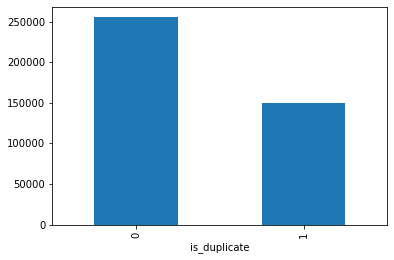

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()
plt.show()

In [7]:
print('total number of questions' , df.shape[0])
print('percentage of duplicate questions are :' , np.round((df[df['is_duplicate'] == 1].shape[0] / df.shape[0])*100,2),"%")
print('percentage of non-duplicate questions are : ' , np.round(100 - (df[df['is_duplicate'] == 1].shape[0] / df.shape[0])*100,2),"%")

total number of questions 404290
percentage of duplicate questions are : 36.92 %
percentage of non-duplicate questions are :  63.08 %


In [12]:
qids = pd.Series(df['qid1'].to_list() + df['qid2'].to_list())
unique_qs = len(np.unique(qids))
qs_more_than_onetime = np.sum(qids.value_counts()>1)
print('Total Number of Unique Questions are : {}'.format(unique_qs))
print('Total number of questions that are repeated  :' ,qs_more_than_onetime )
print('Max number of times a question is repeated : ' , max(qids.value_counts()))

Total Number of Unique Questions are : 537933
Total number of questions that are repeated  : 111780
Max number of times a question is repeated :  157


C:\Users\akshit\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


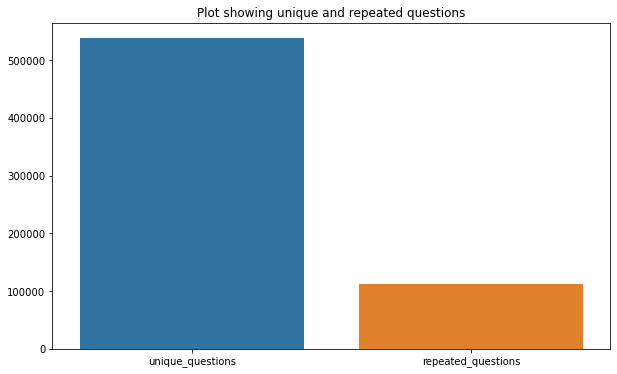

In [13]:
x = ['unique_questions' , 'repeated_questions']
y = [unique_qs , qs_more_than_onetime]
plt.figure(figsize = (10,6))
plt.title('Plot showing unique and repeated questions')
sns.barplot(x , y)
plt.show()

# Checking for Duplicate Pairs

In [14]:
pair_duplicates = df.groupby(['qid1' , 'qid2']).count().reset_index()

In [16]:
print('Number of duplicate questions' , pair_duplicates.shape[0] - df.shape[0])

Number of duplicate questions 0


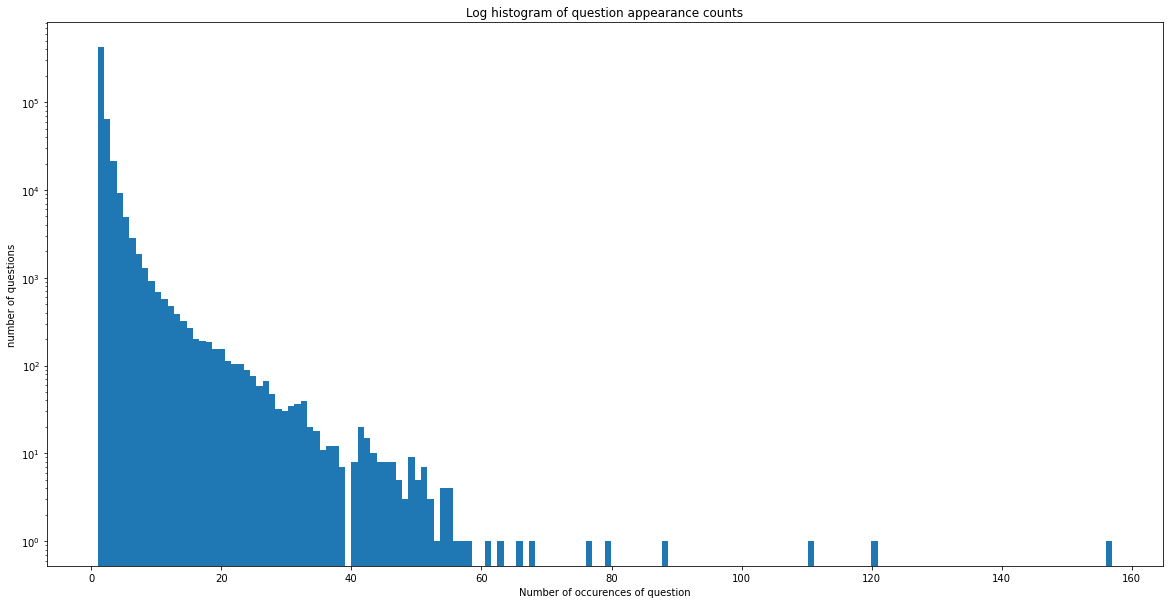

In [21]:
plt.figure(figsize = (20 , 10))
plt.hist(qids.value_counts() , bins = 160)
plt.yscale('log')
plt.title('Log histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('number of questions')
plt.show()

In [29]:
nan_rows = df[df.isnull().any(1)]

In [30]:
nan_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [32]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Basic Feature Extraction before Cleaning

In [50]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row : len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row : len(row.split(" ")))
    
def normalized_word_Common(row):
    w1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip() , row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common , axis = 1)
    
def normalized_word_Total(row):
    w1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip() , row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total , axis = 1)

df['word_Share'] = df['word_Common']/df['word_Total']
    
df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])
    
#df.to_csv('df_fe_without_preprocessing_train.csv' , index = False)
    
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_Share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Analysis of some of the Extracted Features

In [51]:
print('Minimum length of questions in question 1 : ' , min(df['q1_n_words']))
print('Minimum length of questions in question 2 : ' , min(df['q2_n_words']))

Minimum length of questions in question 1 :  1
Minimum length of questions in question 2 :  1


In [52]:
print('Number of questions with minimum length in question 1 : ' , df[df['q1_n_words']==1].shape[0])
print('Number of questions in question 2 with minimum length : ' , df[df['q2_n_words']==1].shape[0])

Number of questions with minimum length in question 1 :  67
Number of questions in question 2 with minimum length :  24


# Feature Word Share

C:\Users\akshit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\akshit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


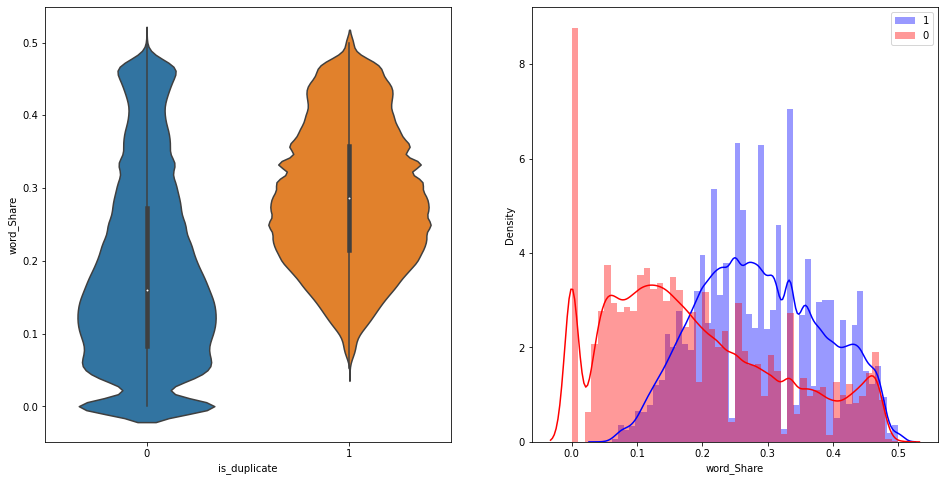

In [60]:
plt.figure(figsize = (16 , 8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'word_Share' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['word_Share'][0:] , label = '1' , color = 'blue')
sns.distplot(df[df['is_duplicate']==0.0]['word_Share'][0:] , label = '0' , color = 'red')
plt.legend()
plt.show()

# word Common

C:\Users\akshit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\akshit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


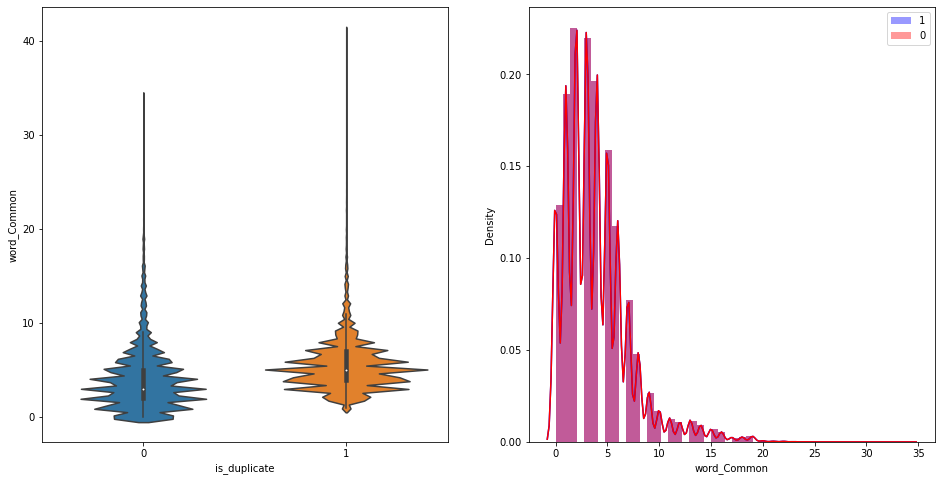

In [59]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate' , y = 'word_Common' , data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==0]['word_Common'][0:] , label = '1' , color = 'blue')
sns.distplot(df[df['is_duplicate']==0]['word_Common'][0:] , label = '0' , color = 'red')
plt.legend()
plt.show()